In [1]:
import requests
import torch
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from diffusers import StableDiffusionInpaintPipeline

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pipe = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting", torch_dtype=torch.float16)
pipe = pipe.to("cuda", torch.float16)

Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


In [3]:
canvas_size = 1536

In [4]:
def create_mask(init_image, canvas_size=canvas_size):
    random_coord = np.random.randint(0,canvas_size//2,2)
    
    x1 = random_coord[0]
    y1 = random_coord[1]
    x2 = x1 + init_image.width
    y2 = y1 + init_image.height
    
    if x2 > canvas_size:
        x2 = canvas_size
        x1 = x2 - init_image.width
        
    if y2 > canvas_size:
        y2 = canvas_size
        y1 = y2 - init_image.height

    input_image = torch.ones((3, canvas_size, canvas_size))
    mask_image = torch.ones((1, canvas_size, canvas_size))
    
    init_image = np.array(init_image)
    init_image_pt = torch.from_numpy(init_image).permute(2, 0, 1) / 255.0
    input_image[:, y1:y2, x1:x2] = init_image_pt
    mask_image[:, y1:y2, x1:x2] = 0.0

    return input_image, mask_image

In [5]:
init_image = Image.open("../media/input_images/167.png").convert("RGB")

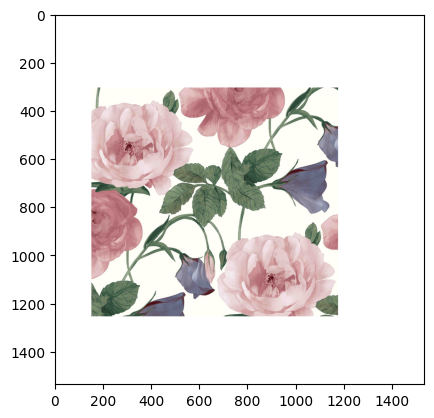

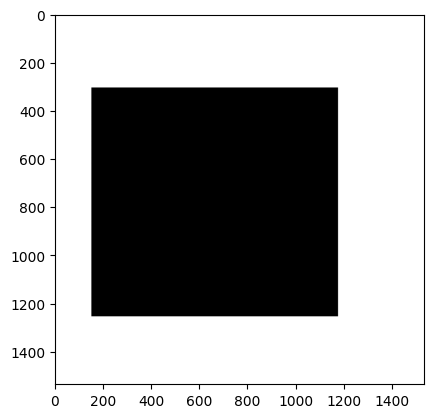

In [6]:
inp, mask = create_mask(init_image)

plt.imshow((inp  * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8))
plt.show()

plt.imshow((mask  * 255).permute(1, 2, 0).cpu().numpy().astype(np.uint8), cmap="gray")
plt.show()

In [ ]:
""" inp = Image.open("media/batik_2.png")
mask = Image.open("media/batik_2_mask.png").convert("L") """

In [7]:
prompt = "flowers pattern"
image = pipe(prompt=" ", 
             image=inp, 
             mask_image=mask, 
             strength=1, 
             num_inference_steps=30,
             num_images_per_prompt=1, 
             width=inp.shape[2],
             height=inp.shape[1],
             guidance_scale=0).images

100%|██████████| 30/30 [00:07<00:00,  3.82it/s]


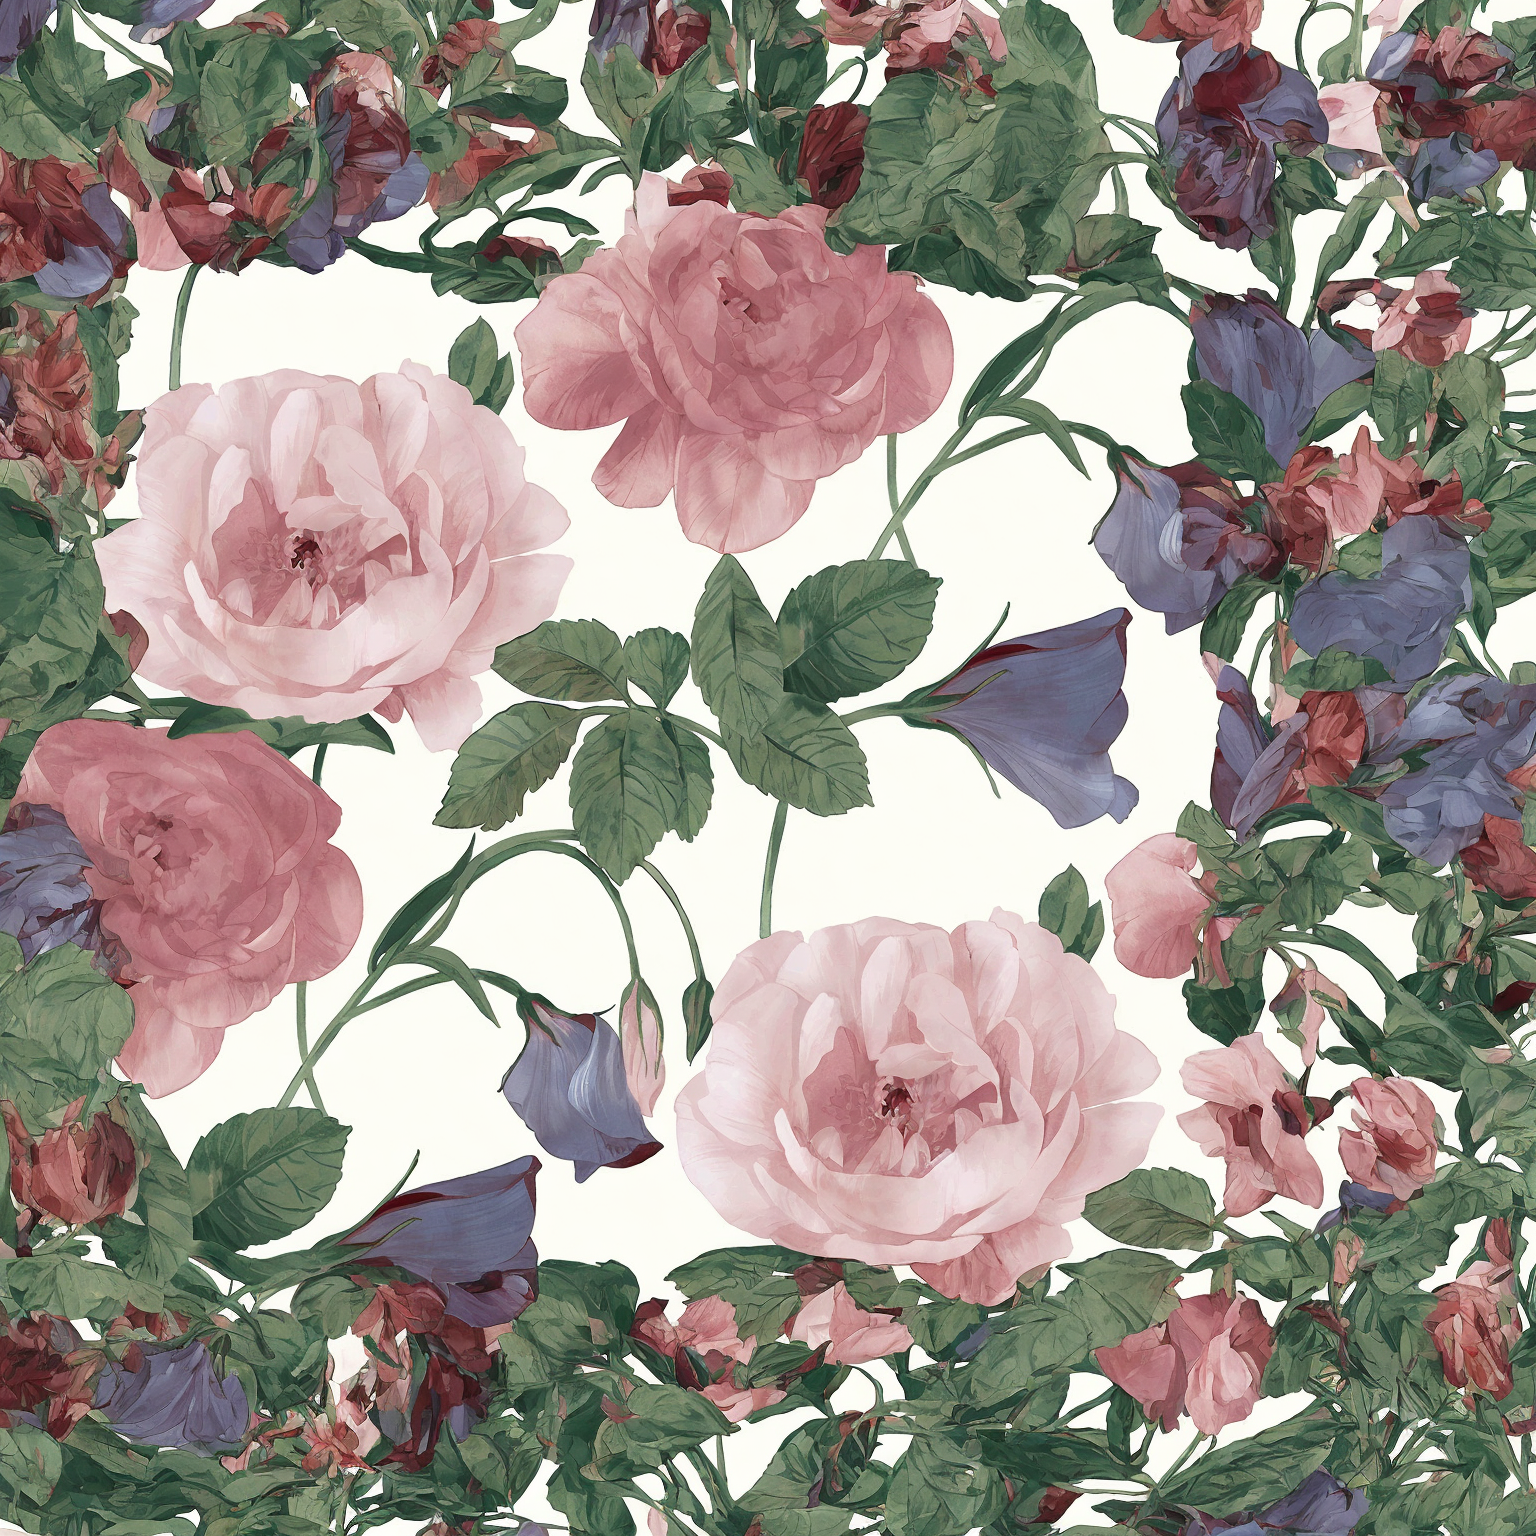

In [8]:
image[0].show()
image[0].save("output.png")